# Obliczamy $\pi$ metodą Monte-Carlo w CUDA.

Pierwszy program wykorzystujący CUDA, będzie obliczał $\pi$ metodą statystyczną. 

Opis metody
-----------

Jedną z metod obliczania przybliżonej wartości liczby $\pi$ jest metoda polegająca na pomiarze prawdopodobieństwa trafiena o obszar, będący kołem. 
Załóżmy, że mamy możliwość wylosowania z rozkładem jednostajnym punktu w kwadracie o jednostkowym boku. Jeżeli teraz zliczymy ilośc punktów zawartych w dowolnej figurze wewnątrz tego kwadratu, to liczba ta będzie proporcjonalna do powierzfchni tej figury. Zastosujmy tą obserwację do koła o promieniu $r = \frac{1}{2}$ wpisanego w nasz kwadrat. Powierznia takiego koła wynosi $P=\pi r^2 = \frac{\pi}{4}$. Obliczając więc stosunek liczby punktów zawartych w tym kole do wszystkich punktów otrzymamy $\frac{\pi}{4}$. 

0. Kiepska metoda obliczania $\pi$
1. Użycie curand oraz równoległej redukcji w pycuda
2. Ile czasu zajmuje posumowanie 4GB RAM ;-)

## Implementacja


Wykorzystamy bibliotekę pyCUDA  w w szczególnosci funkcjonalność gpuarray. Ponadto będziemy korzystać z wbudowanych generatorów liczb losowych. 

Wykorzystanie gpuarray nie wymaga zbyt obszernej wiedzy o architekturze CUDA. Nie będziemy musieli pisać własnego "kernela". Pomino tego gpuaray oferuje niezwykle dużo możliwości, które mogą być przydatne do rozwiązywania problemów napotkanych w naukach ścisłych lub inżynierii.

### Redukcja równoległa


Wysumowanie wartości w wektorze wykonane z wykorzystaniem procesora równoleglego jest zwane problemem redukcji równoległej. Efektywna implementacja redukcji równoległej na CUDA wymaga mistrzowskiej znajomości architektury. Naiwne implementacje z reguły zaniżająpotencjalną wydajność kilka lub kilkadziesiąt razy. W bibliotece pycuda mamy zaimplementowany szablo jądra redukcji, który możemy wykorzytać, nie wnikając w szczegóły jego implementacji. 

### Struktura programu


Nasz program będzie składał się z następujących elementów:

1. Zainicjalizujemy kontekst na wybranym urządzeniu
2. Definiujemy jądro redukcji z szablonu w pyCUDA. Operatorem redukcji będzie suma, a przed wykonaniem operacji wywolujemy funkcję która daje jedynkę jesli punkt należy do naszego koła
3. Generujemy losowe liczby z przedziału $(0,1)$ bezpośrednio w pamięci urządzenia.
4. Wykonujemy jądro na liczbach losowych i dzielimy otrzymaną wartość przez $4$. Powinniśmy otrzymać  przybliżoną wartość $\pi$.

## Co jest ciekawego w tym algorytmie?

Należe podkreślić, że taka metoda obliczania liczby $\pi$ jest wyjątkowo kiepska. Dlateczogo więc chcemy ja zaimplementować i to do tego na GPU?

Poniższa implementacja ma następujące walory dydaktyczne:

1. Pokazuje naocznie jak szybko przebiegają operacje - np. zapełnienia 1GB pamięci liczbami losowymi
2. Korzysta z kernela redukcji równoległej. Jest to niezwykle pożyteczny kernel. Warto zauważyć, że wykonuje on *de facto* operacje identyczną do tej, która występuje w całkowanie numerycznym - czyli liczeniu kwadratury. Innymi słowy mamy szablon programu całkującego!


## Inicjalizacja

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [10]:
import pycuda.gpuarray as gpuarray

import numpy
from pycuda.curandom import rand as curand
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

try:
    ctx.pop()
    ctx.detach()
except:

    print "No CTX!"

cuda.init()
device = cuda.Device(0)
ctx = device.make_context()
print device.name(), device.compute_capability(),device.total_memory()/1024.**3,"GB"
print "W systemie mamy :",cuda.Device.count(), " urządzenia"


GeForce GTX TITAN Black (3, 5) 5.99981689453 GB
W systemie mamy : 2  urządzenia


# Jądro redukcji

Kod operacji wykonanej na każdej parze liczb przed redukcją:

    signbit( (powf(x[i]-0.5f,2.0f)+powf(y[i]-0.5f,2.0f))-0.25f )
    
Zauważmy:

1. Używamy funkcji i zmiennych o pojedyńczej precyzji
2. Funkcja signbit zwraca znak wyrażenia jako liczbę całkowitą




In [11]:
from pycuda.reduction import ReductionKernel

krnl = ReductionKernel(numpy.dtype(numpy.int32), neutral="0",
        reduce_expr="a+b", 
        map_expr="signbit( (powf(x[i]-0.5f,2.0f)+powf(y[i]-0.5f,2.0f))-0.25f )",
        arguments="float *x, float *y")

# Generacja liczb losowych na urządzeniu

Funkcja curand pozwala nam skorzystać z wbudowanego generatora liczb losowych w CUDA. Możemy z jej pomocą zapełnić całą pamięć liczbami losowymi z przedziału $(0,1)$. Sprawdźmy najpiew ile mamy na GPU pamięci:

In [12]:
(free,total)=cuda.mem_get_info()
free,total

(6346547200, 6442254336)

Ponieważ chcemy zapisywać liczny w pojedynczej prezycji, to mamy możliwość zaalokowania pamięci na: 

In [13]:
free/4

1586636800

liczb 4 bajtowych.

In [14]:
%%time 
print cuda.mem_get_info()[0]/1024**2
N = 500000000
a = curand((N/2,))
b = curand((N/2,))
ctx.synchronize()
print cuda.mem_get_info()[0]/1024**2

6052
4144
CPU times: user 36.6 ms, sys: 24.8 ms, total: 61.4 ms
Wall time: 226 ms


### Zadanie

Poeksperymentuj ze zwalnianiem pamięci wykonując np. takie operacje:

    del a
    print cuda.mem_get_info()[0]/1024**2
    del b
    print cuda.mem_get_info()[0]/1024**2

In [15]:
a.get().shape

(250000000,)

In [16]:
%%time 
for i in range(10):
    a1 = a.get()

CPU times: user 1.27 s, sys: 524 ms, total: 1.8 s
Wall time: 1.8 s


In [17]:
cuda.mem_get_info()[0]/1024.**3

4.0477752685546875

In [18]:
%%time 

pole = float(krnl(a, b).get())/(N/2)
ctx.synchronize()

print "OK"

OK
CPU times: user 18.8 ms, sys: 4.4 ms, total: 23.2 ms
Wall time: 23 ms


In [19]:
print 4*pole,"Pi z %d milionów losowań!"%(N/2/1e6)
print np.pi

3.141651952 Pi z 250 milionów losowań!
3.14159265359


## Wykres 

*... warto uważać ile punktów się rysuje...*

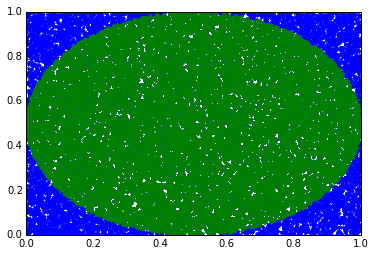

In [20]:
x,y = a.get()[::10000],b.get()[::10000]
plt.plot(x,y,'.')
c = (x-0.5)**2+(y-0.5)**2<0.25
plt.plot(x[c],y[c],'.')
    

In [21]:
try:
    ctx.pop()
    ctx.detach()
    print "OK!"
except:
    print "No CTX!"


OK!


## CPU

Aby się przekonać, czy GPU rzeczywiście wykonał powyższe operacje szybciej niż CPU, sprawdźmy jak szybko wykona się kod skompilowany przez cythona. Cython daje wyniki nie gorsze od czystego "C".

In [22]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [23]:
%%cython

cdef extern from "stdlib.h":
    int RAND_MAX

from libc.stdlib cimport rand
from libc.math cimport pow

def cpu_rand():

    cdef double a,b
    cdef long n=0
    for i in range(5000000):
        a = float(rand())/RAND_MAX
        b = float(rand())/RAND_MAX
        if pow(a-0.5,2.0)+pow(b-0.5,2.0)-0.25<0:
            n=n+1
            
    return n

In [24]:
%%time 
cpu_rand()

CPU times: user 138 ms, sys: 5.73 ms, total: 144 ms
Wall time: 144 ms


3928029

Mamy więc ok 30s na CPU i ok 300ms na GPU - czyli ok 100x !
Należy jednak zauważyć, że na GPU wykonywaliśmy alokację wszystkich liczb w pamięci a potem ich równoległą redukcję. Jest to niezbyt optymalne i można by się spodziewać dalszego wzrostu względnej wydajności jesli by porównywać dokładnie te same algorytmy.

Zobaczmy jeszcze czy na CPU $\pi=3.14$:

In [25]:
628317563/800000000.*4

3.141587815

## Zadania

### Szybsze obliczanie $\pi$ na GPU

Czy można zmodyfikować algorytm tak by obiczał $\pi$ jeszcze szybciej? (oczywiście tą samą metodą). Może warto by z pomocą jednego wątku generować nie jedną liczbę losową ale np 10, lub 100 i obliczać sumę częściową?

### Algorytm na CPU z alokacją pamięci.

Wykonać identyczny funkcjonalnie algorytm na CPU. Użyć C/C++ lub cythona.